In [12]:
import imageio
import os
import random
import cv2
import logging

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from keras.models import load_model
from glob import glob
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

# Helper function

In [4]:
# mask 
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [5]:
def calculate_map(input_image, saved_model):


    test_image = np.expand_dims(input_image, axis=0)
    show_test_image = np.squeeze(test_image)

    decoded_img = saved_model.predict(test_image)
    show_decoded_image = np.squeeze(decoded_img)


    return show_decoded_image

In [6]:
'''
crop the image to satisfy the size of model
crop size = 300 * 300
'''


def crop_fish_eye(image_path):
    
    with Image.open(image_path) as img:
        h,w = img.size
        
        # get mask 
        image_mask = create_circular_mask(w,h,radius=150)
        
        # apply mask to img
        mask = np.stack([image_mask] * 3, axis=-1)
        masked_img = Image.fromarray(img * mask) # change nunmpy array to Image type 
        
        # 300 * 300 crop box centered at central
        crop_box = (h/2 - 150, w/2 -150, h/2 + 150, w/2 + 150) 
        
        cropped_img = masked_img.crop(crop_box)
    return cropped_img

# ACLNet

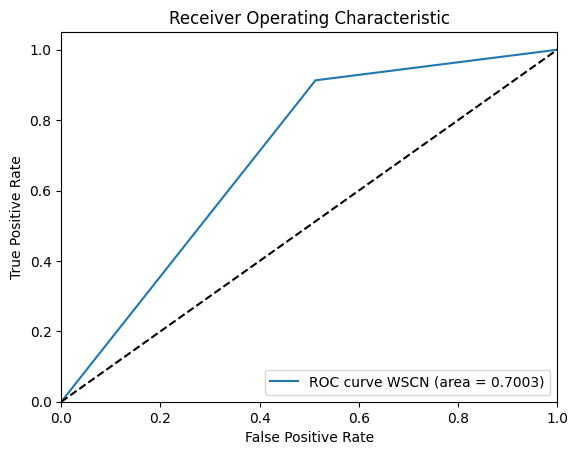

In [33]:
import os 
os.chdir("I:\\Cloud segment models\\ACLNet")

import sys
sys.path.append("./src/models")
sys.path.append("./src/data")
sys.path.append("./src")

import tensorflow as tf
from tqdm import tqdm

from config import *
from loss import *
from utils import *
from dataloader import *

ACLNet_image = "I:\\Cloud segment models\\ACLNet\\data\\imgs"



OG_DIR = os.path.abspath("I:\\Cloud segment models\\Thesis\\Ablation\\Weight/origin")
INFERENCE_DIR = LOG_DIR
logging.basicConfig(level = logging.INFO, filename = os.path.join(LOG_DIR, 'app.log'), format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', filemode='w')

sys.stdout = LoggerWriter(logging.info)
sys.stderr = LoggerWriter(logging.error)

# origin
WEIGHTS_DIR = "I:\\Cloud segment models\\Thesis\\Ablation\\Weight/origin/ACLNet_Best.h5"    
model = tf.keras.models.load_model(WEIGHTS_DIR, custom_objects={"diceCoef":diceCoef, "bceDiceLoss":bceDiceLoss})

trainGen, testGen = getDataLoader(batch_size = 1)
model.evaluate(testGen)
original, prediction = [], []
with tqdm(total = int(6468*TEST_SIZE)) as pbar:
    for data in testGen:
        image, mask = data
        seg = model.predict(image)
        original.append(mask[0].argmax(-1))
        prediction.append(seg[0].argmax(-1))
        pbar.update(1)

original = np.array(original)
prediction = np.array(prediction)

precisions, recalls, f1scores, error_rates = [], [], [], []
with tqdm(total = len(original)) as pbar:
    for orig, pred in zip(original, prediction):
        try:
            precision, recall, f1score, error_rate = score_card(pred, orig)
            precisions.append(precision)
            recalls.append(recall)
            f1scores.append(f1score)
            error_rates.append(error_rate)
        except:
            print('skipped')
        pbar.update(1)

logging.info("[Info] Precision: {}".format(precisions))
logging.info("[Info] Recall: {}".format(recalls))
logging.info("[Info] F1-Score: {}".format(f1scores))
logging.info("[Info] Error Rate: {}".format(error_rates))

org_result =  np.mean(precisions), np.mean(recall), np.mean(f1score), np.mean(error_rate)

logging.info("[Info] Matthews Correlation Coefficient (MCC): ")
logging.info(matthews_corrcoef(original.ravel(), prediction.ravel()))

logging.info("[Info] ROC_AUC Curve: ")
fpr, tpr, thresholds = roc_curve(original.ravel(), prediction.ravel())
auc_score_org = auc(fpr, tpr)

fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve WSCN (area = %0.4f)' % auc_score_org)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")

plt.savefig(os.path.join(INFERENCE_DIR, "ROC_Curve_WSCN.pdf"))

In [34]:
def KNNOutput(image):
        Z = image.reshape((-1,3))
        Z = np.float32(Z)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
        K = 2
        _, label, center=cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        center = np.uint8(center)
        res = center[label.flatten()]
        result = res.reshape((image.shape))
        return result

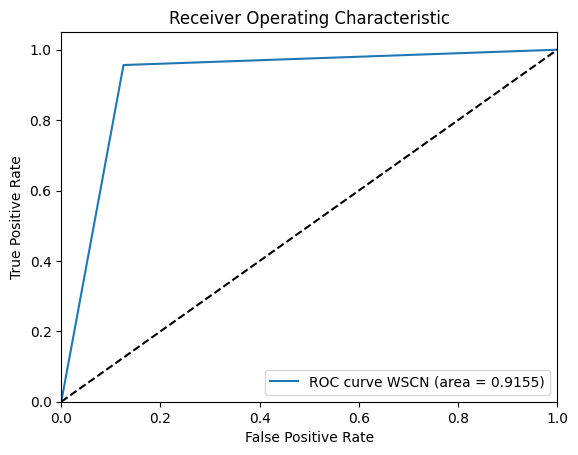

In [35]:
import sys
sys.path.append("./src")
sys.path.append("./src/data/")

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
from dataloader import *
from tqdm import tqdm
from config import *
from utils import *
from loss import *
import numpy as np
import logging
import os

LOG_DIR = os.path.abspath("I:\\Cloud segment models\\Thesis\\Ablation\\Weight\\day\\")
INFERENCE_DIR = LOG_DIR
logging.basicConfig(level = logging.INFO, filename = os.path.join(LOG_DIR, 'app.log'), format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', filemode='w')

sys.stdout = LoggerWriter(logging.info)
sys.stderr = LoggerWriter(logging.error)


# origin and day to nigh
WEIGHTS_DIR = "I:\\Cloud segment models\\Thesis\\Ablation\\Weight/day/ACLNet_Best.h5"    
model = tf.keras.models.load_model(WEIGHTS_DIR, custom_objects={"diceCoef":diceCoef, "bceDiceLoss":bceDiceLoss})

trainGen, testGen = getDataLoader(batch_size = 1)
model.evaluate(testGen)
original, prediction = [], []
with tqdm(total = int(6468*TEST_SIZE)) as pbar:
    for data in testGen:
        image, mask = data
        seg = model.predict(image)
        original.append(mask[0].argmax(-1))
        prediction.append(seg[0].argmax(-1))
        pbar.update(1)

original = np.array(original)
prediction = np.array(prediction)

precisions, recalls, f1scores, error_rates = [], [], [], []
with tqdm(total = len(original)) as pbar:
    for orig, pred in zip(original, prediction):
        try:
            precision, recall, f1score, error_rate = score_card(pred, orig)
            precisions.append(precision)
            recalls.append(recall)
            f1scores.append(f1score)
            error_rates.append(error_rate)
        except:
            print('skipped')
        pbar.update(1)

logging.info("[Info] Precision: {}".format(precisions))
logging.info("[Info] Recall: {}".format(recalls))
logging.info("[Info] F1-Score: {}".format(f1scores))
logging.info("[Info] Error Rate: {}".format(error_rates))

day_result =  np.mean(precisions), np.mean(recall), np.mean(f1score), np.mean(error_rate)

logging.info("[Info] Matthews Correlation Coefficient (MCC): ")
logging.info(matthews_corrcoef(original.ravel(), prediction.ravel()))

logging.info("[Info] ROC_AUC Curve: ")
fpr, tpr, thresholds = roc_curve(original.ravel(), prediction.ravel())
auc_score_day = auc(fpr, tpr)

fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve WSCN (area = %0.4f)' % auc_score_day)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")

plt.savefig(os.path.join(INFERENCE_DIR, "ROC_Curve_WSCN.pdf"))

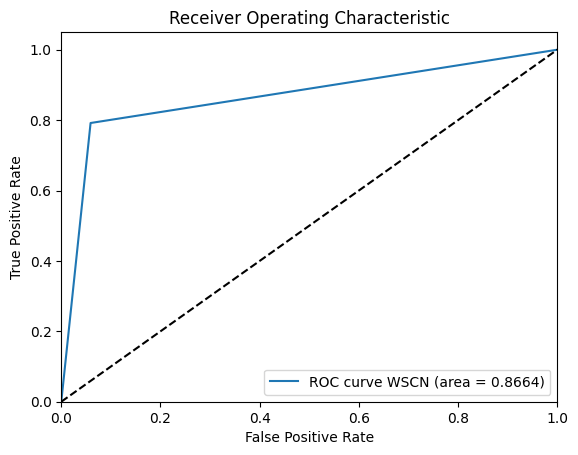

In [36]:


LOG_DIR = os.path.abspath("I:\\Cloud segment models\\Thesis\\Ablation\\Weight/b\\")
INFERENCE_DIR = LOG_DIR
logging.basicConfig(level = logging.INFO, filename = os.path.join(LOG_DIR, 'app.log'), format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', filemode='w')

sys.stdout = LoggerWriter(logging.info)
sys.stderr = LoggerWriter(logging.error)

# origin / day to nigh / night glow
WEIGHTS_DIR = os.path.abspath("I:\\Cloud segment models\\Thesis\\Ablation\\Weight\\b\\ACLNet_Best.h5")
model = tf.keras.models.load_model(WEIGHTS_DIR, custom_objects={"diceCoef":diceCoef, "bceDiceLoss":bceDiceLoss})

trainGen, testGen = getDataLoader(batch_size = 1)
model.evaluate(testGen)
original, prediction = [], []
with tqdm(total = int(6468*TEST_SIZE)) as pbar:
    for data in testGen:
        image, mask = data
        seg = model.predict(image)
        original.append(mask[0].argmax(-1))
        prediction.append(seg[0].argmax(-1))
        pbar.update(1)

original = np.array(original)
prediction = np.array(prediction)

precisions, recalls, f1scores, error_rates = [], [], [], []
with tqdm(total = len(original)) as pbar:
    for orig, pred in zip(original, prediction):
        try:
            precision, recall, f1score, error_rate = score_card(pred, orig)
            precisions.append(precision)
            recalls.append(recall)
            f1scores.append(f1score)
            error_rates.append(error_rate)
        except:
            print('skipped')
        pbar.update(1)

logging.info("[Info] Precision: {}".format(precisions))
logging.info("[Info] Recall: {}".format(recalls))
logging.info("[Info] F1-Score: {}".format(f1scores))
logging.info("[Info] Error Rate: {}".format(error_rates))

logging.info("[Info] Matthews Correlation Coefficient (MCC): ")
logging.info(matthews_corrcoef(original.ravel(), prediction.ravel()))

logging.info("[Info] ROC_AUC Curve: ")
b_result =  np.mean(precisions), np.mean(recall), np.mean(f1score), np.mean(error_rate)
fpr, tpr, thresholds = roc_curve(original.ravel(), prediction.ravel())
auc_score_b = auc(fpr, tpr)

fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve WSCN (area = %0.4f)' % auc_score_b)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")

plt.savefig(os.path.join(INFERENCE_DIR, "ROC_Curve_WSCN.pdf"))

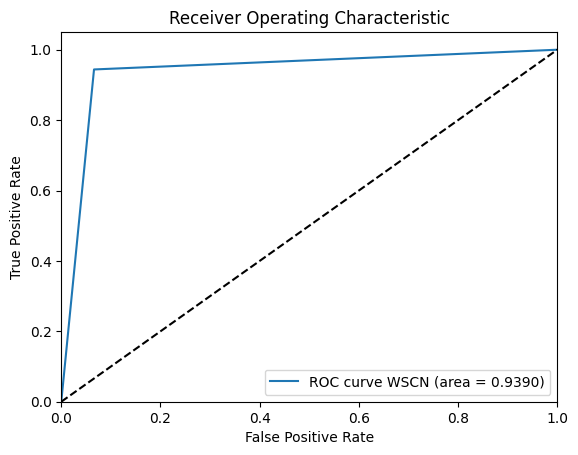

In [37]:



LOG_DIR = os.path.abspath("I:\\Cloud segment models\\Thesis\\Ablation\\Weight/l\\")
INFERENCE_DIR = LOG_DIR
logging.basicConfig(level = logging.INFO, filename = os.path.join(LOG_DIR, 'app.log'), format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', filemode='w')

sys.stdout = LoggerWriter(logging.info)
sys.stderr = LoggerWriter(logging.error)

# origin / day to nigh / night glow / lens flare
WEIGHTS_DIR = "I:\\Cloud segment models\\Thesis\\Ablation\\Weight/l/ACLNet_Best.h5"    
model = tf.keras.models.load_model(WEIGHTS_DIR, custom_objects={"diceCoef":diceCoef, "bceDiceLoss":bceDiceLoss})


trainGen, testGen = getDataLoader(batch_size = 1)
model.evaluate(testGen)
original, prediction = [], []
with tqdm(total = int(6468*TEST_SIZE)) as pbar:
    for data in testGen:
        image, mask = data
        seg = model.predict(image)
        original.append(mask[0].argmax(-1))
        prediction.append(seg[0].argmax(-1))
        pbar.update(1)

original = np.array(original)
prediction = np.array(prediction)

precisions, recalls, f1scores, error_rates = [], [], [], []
with tqdm(total = len(original)) as pbar:
    for orig, pred in zip(original, prediction):
        try:
            precision, recall, f1score, error_rate = score_card(pred, orig)
            precisions.append(precision)
            recalls.append(recall)
            f1scores.append(f1score)
            error_rates.append(error_rate)
        except:
            print('skipped')
        pbar.update(1)

logging.info("[Info] Precision: {}".format(precisions))
logging.info("[Info] Recall: {}".format(recalls))
logging.info("[Info] F1-Score: {}".format(f1scores))
logging.info("[Info] Error Rate: {}".format(error_rates))

logging.info("[Info] Matthews Correlation Coefficient (MCC): ")
logging.info(matthews_corrcoef(original.ravel(), prediction.ravel()))

logging.info("[Info] ROC_AUC Curve: ")
l_result =  np.mean(precisions), np.mean(recall), np.mean(f1score), np.mean(error_rate)
fpr, tpr, thresholds = roc_curve(original.ravel(), prediction.ravel())
auc_score_l = auc(fpr, tpr)

fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve WSCN (area = %0.4f)' % auc_score_l)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")

plt.savefig(os.path.join(INFERENCE_DIR, "ROC_Curve_WSCN.pdf"))

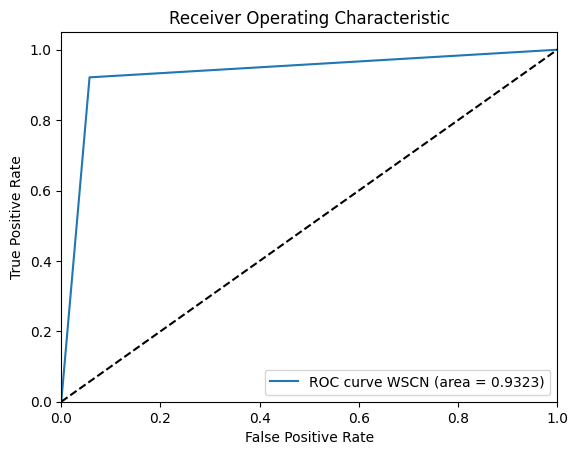

In [38]:


LOG_DIR = os.path.abspath("I:\\Cloud segment models\\Thesis\\Ablation\\Weight/f\\")
INFERENCE_DIR = LOG_DIR
logging.basicConfig(level = logging.INFO, filename = os.path.join(LOG_DIR, 'app.log'), format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', filemode='w')

sys.stdout = LoggerWriter(logging.info)
sys.stderr = LoggerWriter(logging.error)

# origin / day to nigh / night glow / lens flare / fish eye transform
WEIGHTS_DIR = "I:\\Cloud segment models\\Thesis\\Ablation\\Weight/f/ACLNet_Best.h5"    
model = tf.keras.models.load_model(WEIGHTS_DIR, custom_objects={"diceCoef":diceCoef, "bceDiceLoss":bceDiceLoss})

trainGen, testGen = getDataLoader(batch_size = 1)
model.evaluate(testGen)
original, prediction = [], []
with tqdm(total = int(6468*TEST_SIZE)) as pbar:
    for data in testGen:
        image, mask = data
        seg = model.predict(image)
        original.append(mask[0].argmax(-1))
        prediction.append(seg[0].argmax(-1))
        pbar.update(1)

original = np.array(original)
prediction = np.array(prediction)

precisions, recalls, f1scores, error_rates = [], [], [], []
with tqdm(total = len(original)) as pbar:
    for orig, pred in zip(original, prediction):
        try:
            precision, recall, f1score, error_rate = score_card(pred, orig)
            precisions.append(precision)
            recalls.append(recall)
            f1scores.append(f1score)
            error_rates.append(error_rate)
        except:
            print('skipped')
        pbar.update(1)

logging.info("[Info] Precision: {}".format(precisions))
logging.info("[Info] Recall: {}".format(recalls))
logging.info("[Info] F1-Score: {}".format(f1scores))
logging.info("[Info] Error Rate: {}".format(error_rates))

logging.info("[Info] Matthews Correlation Coefficient (MCC): ")
logging.info(matthews_corrcoef(original.ravel(), prediction.ravel()))

logging.info("[Info] ROC_AUC Curve: ")
f_result =  np.mean(precisions), np.mean(recall), np.mean(f1score), np.mean(error_rate)
fpr, tpr, thresholds = roc_curve(original.ravel(), prediction.ravel())
auc_score_f = auc(fpr, tpr)

fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve WSCN (area = %0.4f)' % auc_score_f)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")


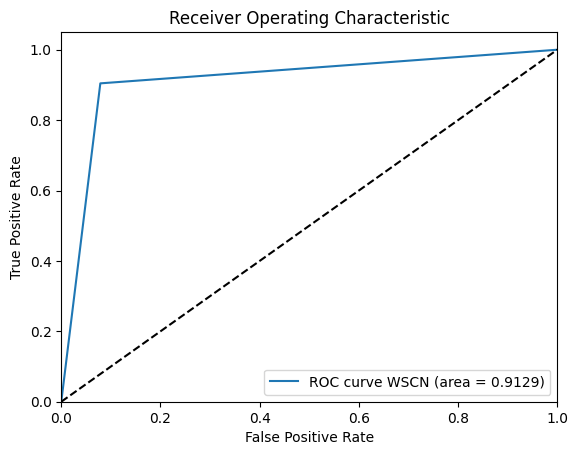

In [39]:
# complete


LOG_DIR = os.path.abspath("I:\\Cloud segment models\\Thesis\\Ablation\\Weight")
INFERENCE_DIR = LOG_DIR
logging.basicConfig(level = logging.INFO, filename = os.path.join(LOG_DIR, 'app.log'), format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', filemode='w')

sys.stdout = LoggerWriter(logging.info)
sys.stderr = LoggerWriter(logging.error)

WEIGHTS_DIR = "I:\\Cloud segment models\\ACLNet_modify\\weights\\Weight_original/ACLNet_Best.h5"    
model = tf.keras.models.load_model(WEIGHTS_DIR, custom_objects={"diceCoef":diceCoef, "bceDiceLoss":bceDiceLoss})

trainGen, testGen = getDataLoader(batch_size = 1)
model.evaluate(testGen)
original, prediction = [], []
with tqdm(total = int(6468*TEST_SIZE)) as pbar:
    for data in testGen:
        image, mask = data
        seg = model.predict(image)
        original.append(mask[0].argmax(-1))
        prediction.append(seg[0].argmax(-1))
        pbar.update(1)

original = np.array(original)
prediction = np.array(prediction)

precisions, recalls, f1scores, error_rates = [], [], [], []
with tqdm(total = len(original)) as pbar:
    for orig, pred in zip(original, prediction):
        try:
            precision, recall, f1score, error_rate = score_card(pred, orig)
            precisions.append(precision)
            recalls.append(recall)
            f1scores.append(f1score)
            error_rates.append(error_rate)
        except:
            print('skipped')
        pbar.update(1)

logging.info("[Info] Precision: {}".format(precisions))
logging.info("[Info] Recall: {}".format(recalls))
logging.info("[Info] F1-Score: {}".format(f1scores))
logging.info("[Info] Error Rate: {}".format(error_rates))

logging.info("[Info] Matthews Correlation Coefficient (MCC): ")
logging.info(matthews_corrcoef(original.ravel(), prediction.ravel()))

logging.info("[Info] ROC_AUC Curve: ")
comp_result = np.mean(precisions), np.mean(recall), np.mean(f1score), np.mean(error_rate)
fpr, tpr, thresholds = roc_curve(original.ravel(), prediction.ravel())
auc_score_comp = auc(fpr, tpr)

fig, ax = plt.subplots(1,1)
ax.plot(fpr, tpr, label='ROC curve WSCN (area = %0.4f)' % auc_score_comp)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")

plt.savefig(os.path.join(INFERENCE_DIR, "ROC_Curve_WSCN.pdf"))

In [ ]:
comp_result = np.mean(precisions), np.mean(recall), np.mean(f1score), np.mean(error_rate)
print(precision)

0.9930586455459642

In [40]:
org_result,day_result, b_result, l_result, f_result, comp_result

((0.6946156686704167,
  0.9187902548305796,
  0.7090398297759161,
  0.42204378858024694),
 (0.8828166068204976,
  0.7802167029274282,
  0.8660513605279518,
  0.13507908950617284),
 (0.9200439914820369,
  0.5840208517329772,
  0.7337085949339686,
  0.23726851851851852),
 (0.9280964527223013,
  0.9066195635783987,
  0.9194438072768183,
  0.08891541280864197),
 (0.9361585180541268,
  0.6240871981560864,
  0.7653111090565689,
  0.21422887731481483),
 (0.9121768335802607,
  0.7158951381858131,
  0.8319939917386406,
  0.16182002314814814))

1/1 [==============================] - 1s 733ms/step


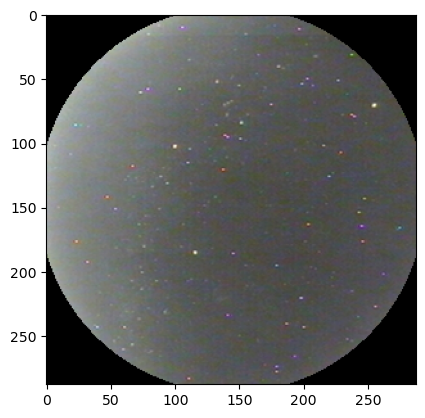

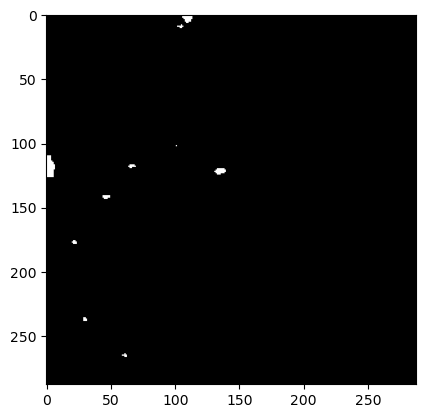

In [14]:
import os 
os.chdir("F:\\Cloud segment models\\ACLNet")

import sys
sys.path.append("./src/models")

import tensorflow as tf
from loss import *

ACLNet_image = "F:\\Cloud segment models\\ACLNet\\data\\imgs"


WEIGHTS_DIR = "F:\\Cloud segment models\\Thesis\\Ablation\\Weight/day/ACLNet_Best.h5"    
model = tf.keras.models.load_model(WEIGHTS_DIR, custom_objects={"diceCoef":diceCoef, "bceDiceLoss":bceDiceLoss})



resize_size = (288, 288)


f_path = "F:\\CloudDataset\\weather\\moonglow\\Night/01-02-2024_21%3A35%3A02_moonglow.png" 

# filename, suffix = f.split(".")
# save_name = filename+"_GT"

# image = cv2.imread(f_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = cv2.resize(image, resize_size)


# image_mask_150 = create_circular_mask(w,h,radius=150)   


# # apply mask to img with full image 
# mask_150 = np.stack([image_mask_150] * 3, axis=-1)
# masked_img_150 = image_np * mask_150

# masked_img_150 = np.array(crop_center(Image.fromarray(masked_img_150),288,288))

# image_np = np.array(image)

# knn_img_150=KNNOutput(image_np)


# image_np = np.expand_dims(image_np,axis = 0)
# knn_img_150 = np.expand_dims(knn_img_150,axis = 0)
# img_150=(image_np,knn_img_150/255)

# seg_150 = model.predict(img_150)
# mask_150 = seg_150[0].argmax(-1)*255
# mask_150 = Image.fromarray(mask_150.astype("uint8"))



# # apply threshold and get binary maska/
# threshold = 0.6
# result = np.zeros(seg_150[0][:,:,1].shape)
# result[seg_150[0][:,:,1] > threshold] = 255
# result = Image.fromarray(result.astype("uint8"), 'L')

img = Image.open(f_path)
image_np = np.array(img)
h,w = img.size
image_mask_150 = create_circular_mask(w,h,radius=150)   


# apply mask to img with full image 
mask_150 = np.stack([image_mask_150] * 3, axis=-1)
masked_img_150 = image_np * mask_150

masked_img_150 = np.array(crop_center(Image.fromarray(masked_img_150),288,288))

# generate KNN image 
knn_img_150=KNNOutput(masked_img_150)



masked_img_150 = np.expand_dims(masked_img_150,axis = 0)
knn_img_150 = np.expand_dims(knn_img_150,axis = 0)

img_150=(masked_img_150,knn_img_150/255) # image sturecture input into model 

seg_150 = model.predict(img_150)
mask_150 = seg_150[0].argmax(-1)*255
mask_150 = Image.fromarray(mask_150.astype("uint8"))

prob_150 = (seg_150[0][:,:,1] * 255).astype(np.uint8)

# add text information to image 
masked_img_150 = Image.fromarray(masked_img_150[0])

prob_150 = Image.fromarray(prob_150)
knn_img_150 = Image.fromarray(knn_img_150[0])

plt.imshow(masked_img_150,cmap = "gray")
plt.show()
plt.imshow(mask_150,cmap = "gray")
plt.show()

In [9]:
def KNNOutput(image):
        Z = image.reshape((-1,3))
        Z = np.float32(Z)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
        K = 2
        _, label, center=cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        center = np.uint8(center)
        res = center[label.flatten()]
        result = res.reshape((image.shape))
        return result
    
def crop_center(image, new_width, new_height):
    width, height = image.size
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = (width + new_width) // 2
    bottom = (height + new_height) // 2
    return image.crop((left, top, right, bottom))

1/1 [==============================] - 1s 743ms/step


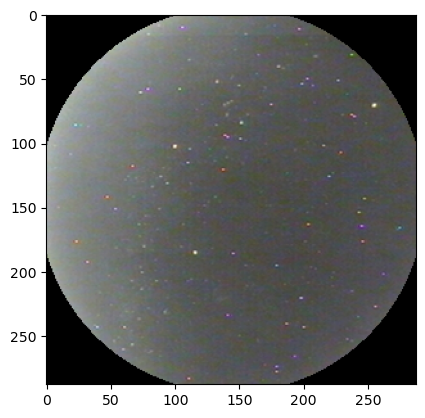

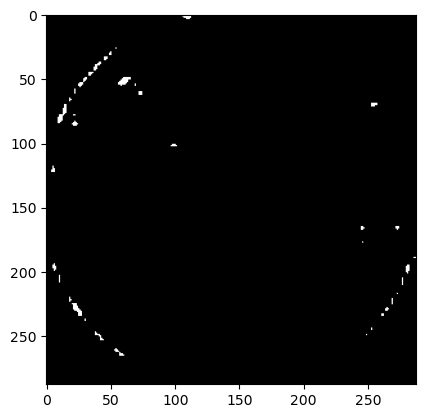

In [12]:
WEIGHTS_DIR = "F:\\Cloud segment models\\ACLNet\\weights/ACLNet_Best.h5" 
model = tf.keras.models.load_model(WEIGHTS_DIR, custom_objects={"diceCoef":diceCoef, "bceDiceLoss":bceDiceLoss})



resize_size = (288, 288)


f_path = "F:\\CloudDataset\\weather\\moonglow\\Night/01-02-2024_21%3A35%3A02_moonglow.png" 

img = Image.open(f_path)
image_np = np.array(img)
h,w = img.size
image_mask_150 = create_circular_mask(w,h,radius=150)   


# apply mask to img with full image 
mask_150 = np.stack([image_mask_150] * 3, axis=-1)
masked_img_150 = image_np * mask_150

masked_img_150 = np.array(crop_center(Image.fromarray(masked_img_150),288,288))

# generate KNN image 
knn_img_150=KNNOutput(masked_img_150)



masked_img_150 = np.expand_dims(masked_img_150,axis = 0)
knn_img_150 = np.expand_dims(knn_img_150,axis = 0)

img_150=(masked_img_150,knn_img_150/255) # image sturecture input into model 

seg_150 = model.predict(img_150)
mask_150 = seg_150[0].argmax(-1)*255
mask_150 = Image.fromarray(mask_150.astype("uint8"))

prob_150 = (seg_150[0][:,:,1] * 255).astype(np.uint8)




# add text information to image 
masked_img_150 = Image.fromarray(masked_img_150[0])

prob_150 = Image.fromarray(prob_150)
knn_img_150 = Image.fromarray(knn_img_150[0])



# # combine three image horizontally 
# print("start")
# height = max(masked_img_150.height, prob_150.height, result.height,knn_img_150.height)
# total_width = masked_img_150.width + prob_150.width + result.width + knn_img_150.width + 3 * padding 
# combined_image = Image.new('RGB', (total_width, height), "white")
# combined_image.paste(masked_img_150, (0, 0))
# combined_image.paste(prob_150, (masked_img_150.width + padding, 0))
# combined_image.paste(result, (masked_img_150.width + prob_150.width + 2*padding, 0))
# combined_image.paste(knn_img_150, (masked_img_150.width + prob_150.width + result.width + 3*padding, 0))

plt.imshow(masked_img_150,cmap = "gray")
plt.show()
plt.imshow(mask_150,cmap = "gray")
plt.show()

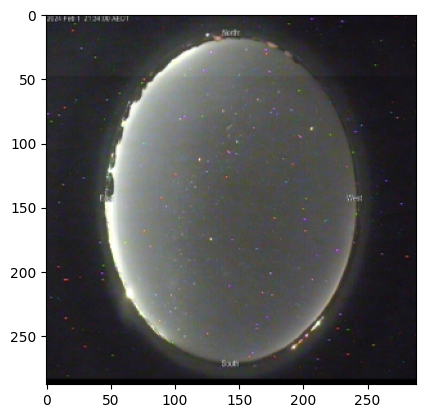

In [55]:
plt.imshow(image)